**Reg2 - Modelo 2**

*Generales*

In [48]:
import sys
import os

sys.path.append(os.path.abspath('../package'))
%load_ext autoreload
%autoreload 2

from functions.data_loader import load_excel_data
file = "../../data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = load_excel_data(file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Archivo cargado correctamente desde ../../data/BASE DE DATOS PCC_cleaned.xlsx


*Preparación de los datos* - Modelo 2

In [49]:

from functions.data_preparation import prepare_regression_data

features = {
    'maquina': 'categorical',
    'seccion': 'categorical',
    'proceso': 'categorical',
    'usuario': 'categorical',
    'fabricadas': 'numeric',
    'hora_inicio': 'numeric',
    'dia_semana_inicio': 'categorical',
    'turno': 'categorical'
}

X_train, X_test, y_train, y_test, _, _ = prepare_regression_data(df_char,features,"duracion_min")

Data prepared: 14608 training samples, 3653 test samples.
Categorical features encoded: ['maquina', 'seccion', 'proceso', 'usuario', 'dia_semana_inicio', 'turno']


In [50]:
from functions.data_preparation import select_features_lasso
features_lasso = select_features_lasso(X_train, y_train,  X_test=X_test, y_test=y_test)

Lasso coefficients:
maquina              -4.256991
seccion               9.084290
proceso               1.171373
usuario              -0.155240
fabricadas           25.725629
hora_inicio          -0.641885
dia_semana_inicio    -0.157784
turno                -3.015153
dtype: float64

Selected features by Lasso:
['maquina', 'seccion', 'proceso', 'usuario', 'fabricadas', 'hora_inicio', 'dia_semana_inicio', 'turno']

R² on test set: 0.2620


In [51]:
from functions.data_preparation import select_features_ols
features_ols,_ = select_features_ols(X_train, y_train, p_threshold=0.05)

P-values:
maquina              1.549844e-192
seccion               1.240006e-52
proceso               2.493724e-23
usuario               2.259700e-04
fabricadas            0.000000e+00
hora_inicio           1.381369e-01
dia_semana_inicio     3.431552e-01
turno                 5.295993e-09
dtype: float64

Significant features (p <= 0.05):
['maquina', 'seccion', 'proceso', 'usuario', 'fabricadas', 'turno']


In [52]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
#Todos (regresion lineal) estos modelos son sensibles al encoder (El encoder OrdinalEncoder utilizado supone un orden en las variables aunque nosotros tenemos variables que no son ordenables, eso explica su bajo rendimiento respecto a los modelos que no asumen esto)
#Sin embargo, no sería práctico en este caso transformar todas las categoricas a OneHotEncoder porque eso adicionaria muchas columnas (variables mas) al modelo
models = {
    'LinearRegression': {
        'model': LinearRegression(fit_intercept=True), #Para garantizar el BIAS 
        'params': {}
    },
    'Lasso': {
        'model': Lasso(fit_intercept=True), #Para garantizar el BIAS
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge': {
        'model': Ridge(fit_intercept=True),#Para garantizar el BIAS
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42), #No necesita BIAS
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),#No necesita BIAS
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),#No necesita BIAS
        'params': {
            'n_neighbors': [1,3, 5, 7, 9, 11,15,20,25,30,35,40],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
        }
    }
}

In [53]:
#Entrenar ahora si el encoder y scaler con las variables seleccionadas
features_ols_dict = {col: features[col] for col in features_ols}
X_train_selected, X_test_selected, y_train_selected, y_test_selected, encoder, scaler = prepare_regression_data(df_char,features_ols_dict,"duracion_min")

Data prepared: 14608 training samples, 3653 test samples.
Categorical features encoded: ['maquina', 'seccion', 'proceso', 'usuario', 'turno']


In [54]:
from functions.model_evaluation import evaluate_regression_models

tuned_results, summary_metrics, all_grid,best_models = evaluate_regression_models(
    models,
    X_train_selected, y_train_selected,
    X_test=X_test_selected,
    y_test=y_test_selected,
    scoring="neg_root_mean_squared_error",
    cv=5
)

Evaluating: LinearRegression
Best Params                 {}
RMSE CV              46.176904
MAE CV               33.372446
R2 CV                 0.260242
RMSE Test            47.043156
MAE Test             34.476706
R2 Test               0.262422
Training Time (s)     2.803248
dtype: object


Evaluating: Lasso
Best Params          {'alpha': 0.001}
RMSE CV                     46.176903
MAE CV                      33.372441
R2 CV                        0.260242
RMSE Test                   47.043186
MAE Test                    34.476712
R2 Test                      0.262421
Training Time (s)            2.165141
dtype: object


Evaluating: Ridge
Best Params          {'alpha': 10.0}
RMSE CV                    46.176885
MAE CV                     33.373038
R2 CV                       0.260243
RMSE Test                  47.043081
MAE Test                   34.476789
R2 Test                     0.262424
Training Time (s)           0.117576
dtype: object


Evaluating: RandomForest
Best Params   

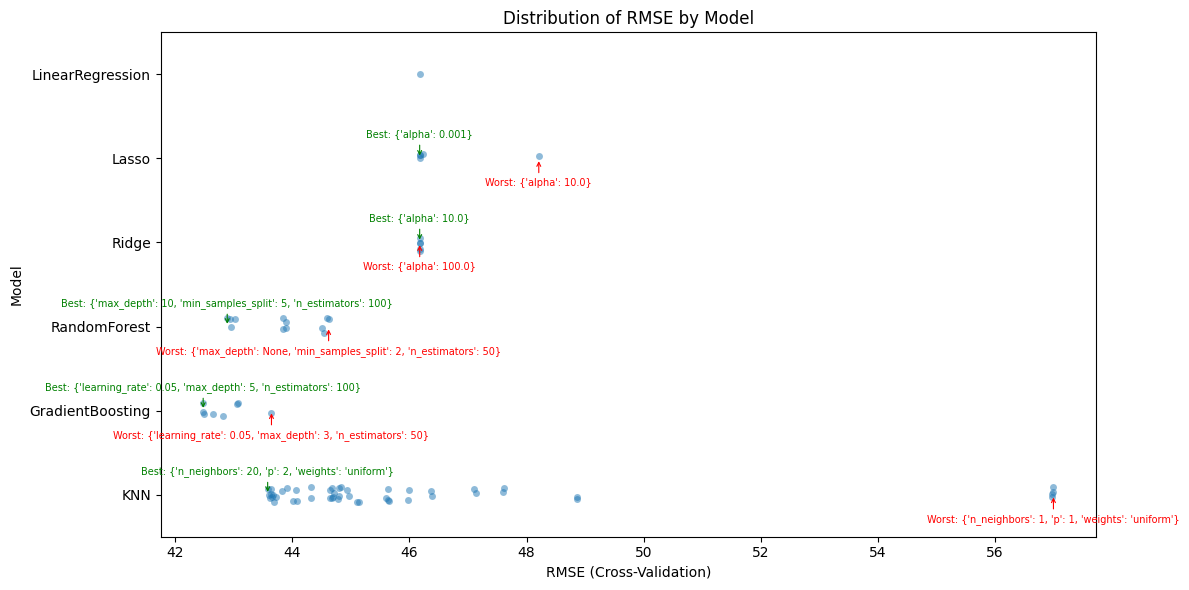

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
0,0.006506,0.000462,0.002603,0.000482,{},-46.189536,-45.998304,-47.123759,-45.563424,-45.994735,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.173952
1,0.008890,0.000268,0.003238,0.000766,{'alpha': 0.001},-46.189462,-45.998340,-47.123750,-45.563405,-45.994799,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.173951
2,0.008078,0.000831,0.003630,0.000999,{'alpha': 0.01},-46.188805,-45.998665,-47.123677,-45.563241,-45.995387,...,Lasso,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.173955
3,0.009557,0.000632,0.004127,0.000975,{'alpha': 0.1},-46.182753,-46.002432,-47.123430,-45.562111,-46.001737,...,Lasso,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.174492
4,0.009550,0.000640,0.004007,0.001113,{'alpha': 1.0},-46.174710,-46.091703,-47.168604,-45.602230,-46.113219,...,Lasso,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.230093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.027229,0.005525,0.156833,0.040482,"{'n_neighbors': 35, 'p': 2, 'weights': 'distan...",-44.511020,-44.712658,-45.831243,-44.382086,-43.765942,...,KNN,NaN,NaN,NaN,NaN,NaN,35.0,2.0,distance,44.640590
75,0.029025,0.010488,0.169584,0.060875,"{'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}",-43.563449,-44.294767,-44.856415,-43.545138,-43.814999,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,uniform,44.014953
76,0.023829,0.002292,0.145043,0.025288,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",-44.539744,-44.828268,-45.880517,-44.363740,-43.767812,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,distance,44.676016
77,0.022064,0.003417,0.096649,0.008104,"{'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-43.488666,-44.094984,-44.685409,-43.493289,-43.793204,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,uniform,43.911110


In [55]:
from functions.plotter import plot_cv_metric_distribution
plot_cv_metric_distribution([all_grid], metric_name="rmse", maximize=False)

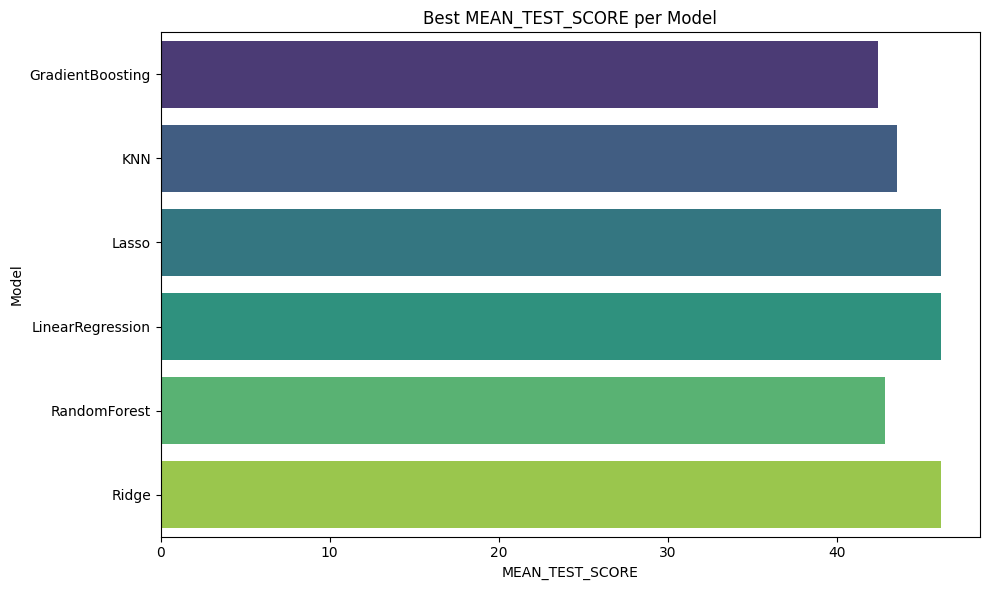

In [56]:
from functions.plotter import plot_best_metric_per_model
best_rmse_df = plot_best_metric_per_model([all_grid], metric='mean_test_score', maximize=False)

In [57]:
from functions.model_transformer import CustomPreprocessor
preprocessor = CustomPreprocessor(encoder, scaler, features_ols_dict)

In [58]:
from functions.save_models import save_pipeline_models
save_path = "./results/reg2"
save_pipeline_models(preprocessor, best_models,save_path)

Guardado pipeline: ./results/reg2\LinearRegression_pipeline.joblib
Guardado pipeline: ./results/reg2\Lasso_pipeline.joblib
Guardado pipeline: ./results/reg2\Ridge_pipeline.joblib
Guardado pipeline: ./results/reg2\RandomForest_pipeline.joblib
Guardado pipeline: ./results/reg2\GradientBoosting_pipeline.joblib
Guardado pipeline: ./results/reg2\KNN_pipeline.joblib


In [ ]:
#Cargar el dataset de nuevo - Solo para probar el comportamiento del modelo graficamente
from sklearn.model_selection import train_test_split
from functions.data_loader import load_excel_data
file = "../../data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = load_excel_data(file)

X = df_char[features_ols]
y = df_char['duracion_min'] 
X_train_original = X.loc[X_train_selected.index]
X_test_original = X.loc[X_test_selected.index]
y_train_original = y.loc[X_train_selected.index]
y_test_original = y.loc[X_test_selected.index] #Asegurando el mismo seed para que la division sea igual

Archivo cargado correctamente desde ../../data/BASE DE DATOS PCC_cleaned.xlsx


In [60]:
#Comportamiento del mejor modelo (menor RMSE) - o el modelo que se quiere ver
from joblib import load
from sklearn.pipeline import Pipeline
model_name = "GradientBoosting"
# Ruta al archivo
pipeline_path = os.path.join("results", "reg2", f"{model_name}_pipeline.joblib")

# Cargar el pipeline completo (encoder + scaler + modelo)
pipeline:Pipeline = load(pipeline_path)

y_train_pred = pipeline.predict(X_train_original)
y_test_pred = pipeline.predict(X_test_original)


C:\Users\yosse\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\yosse\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#Solo para comprobar funcionamiento correcto del model transformer
import pandas as pd

# Transformar con el preprocessor (numpy array)
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train_original)


# Convertir a DataFrame con esos nombres
df_transformed = pd.DataFrame(X_transformed, columns=features_ols, index=X_train_original.index)

print(df_transformed.head())
print("-"*50)
print(X_train_selected.head())



       maquina  seccion  proceso  usuario  fabricadas  turno
15975      7.0      1.0     16.0     13.0   -0.526318    1.0
16358      0.0      0.0     16.0      9.0   -0.526318    0.0
4467       1.0      0.0     10.0     23.0    1.118233    2.0
16999     10.0      2.0     16.0     28.0   -0.526318    1.0
9688       7.0      1.0     16.0     26.0   -0.526318    0.0
--------------------------------------------------
       maquina  seccion  proceso  usuario  fabricadas  turno
15975      7.0      1.0     16.0     13.0   -0.526318    1.0
16358      0.0      0.0     16.0      9.0   -0.526318    0.0
4467       1.0      0.0     10.0     23.0    1.118233    2.0
16999     10.0      2.0     16.0     28.0   -0.526318    1.0
9688       7.0      1.0     16.0     26.0   -0.526318    0.0


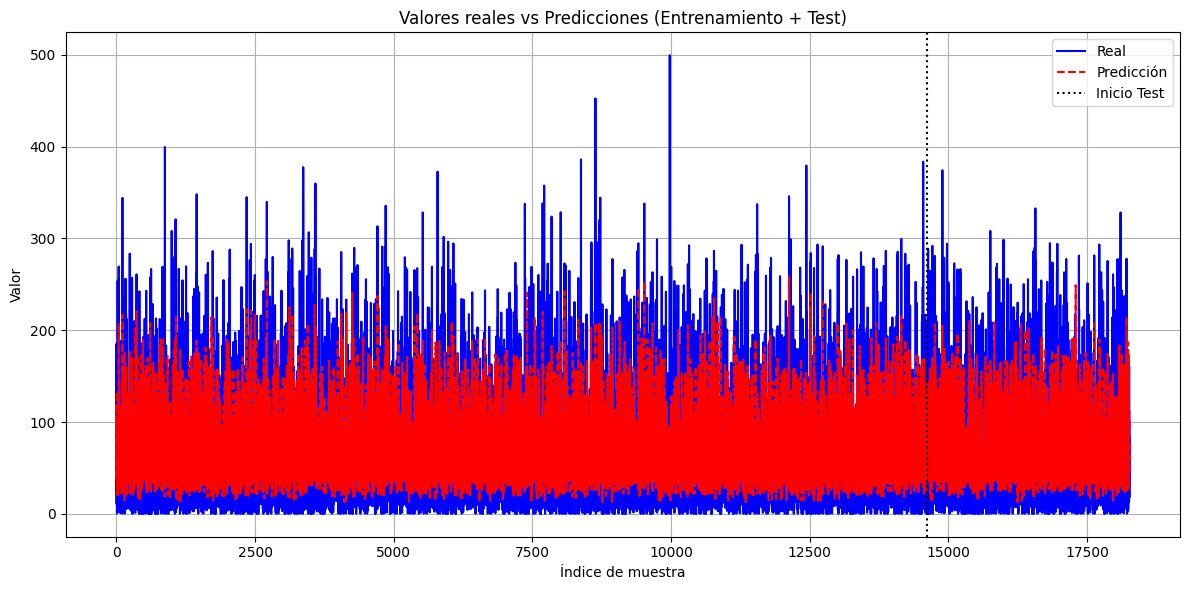

In [62]:
from functions.plotter import plot_dataprediction


plot_dataprediction(y_train=y_train_selected,y_test=y_test_selected,y_pred_test=y_test_pred,y_pred_train=y_train_pred)

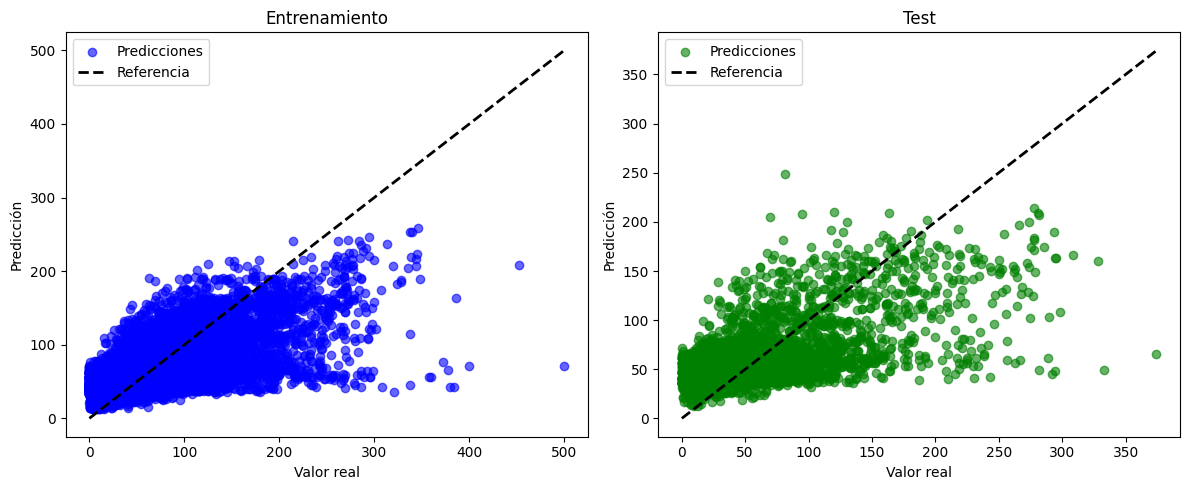

In [63]:
from functions.plotter import plot_dataprediction, plot_dataprediction_comparison


plot_dataprediction_comparison(y_train=y_train_selected,y_test=y_test_selected,y_pred_test=y_test_pred,y_pred_train=y_train_pred)

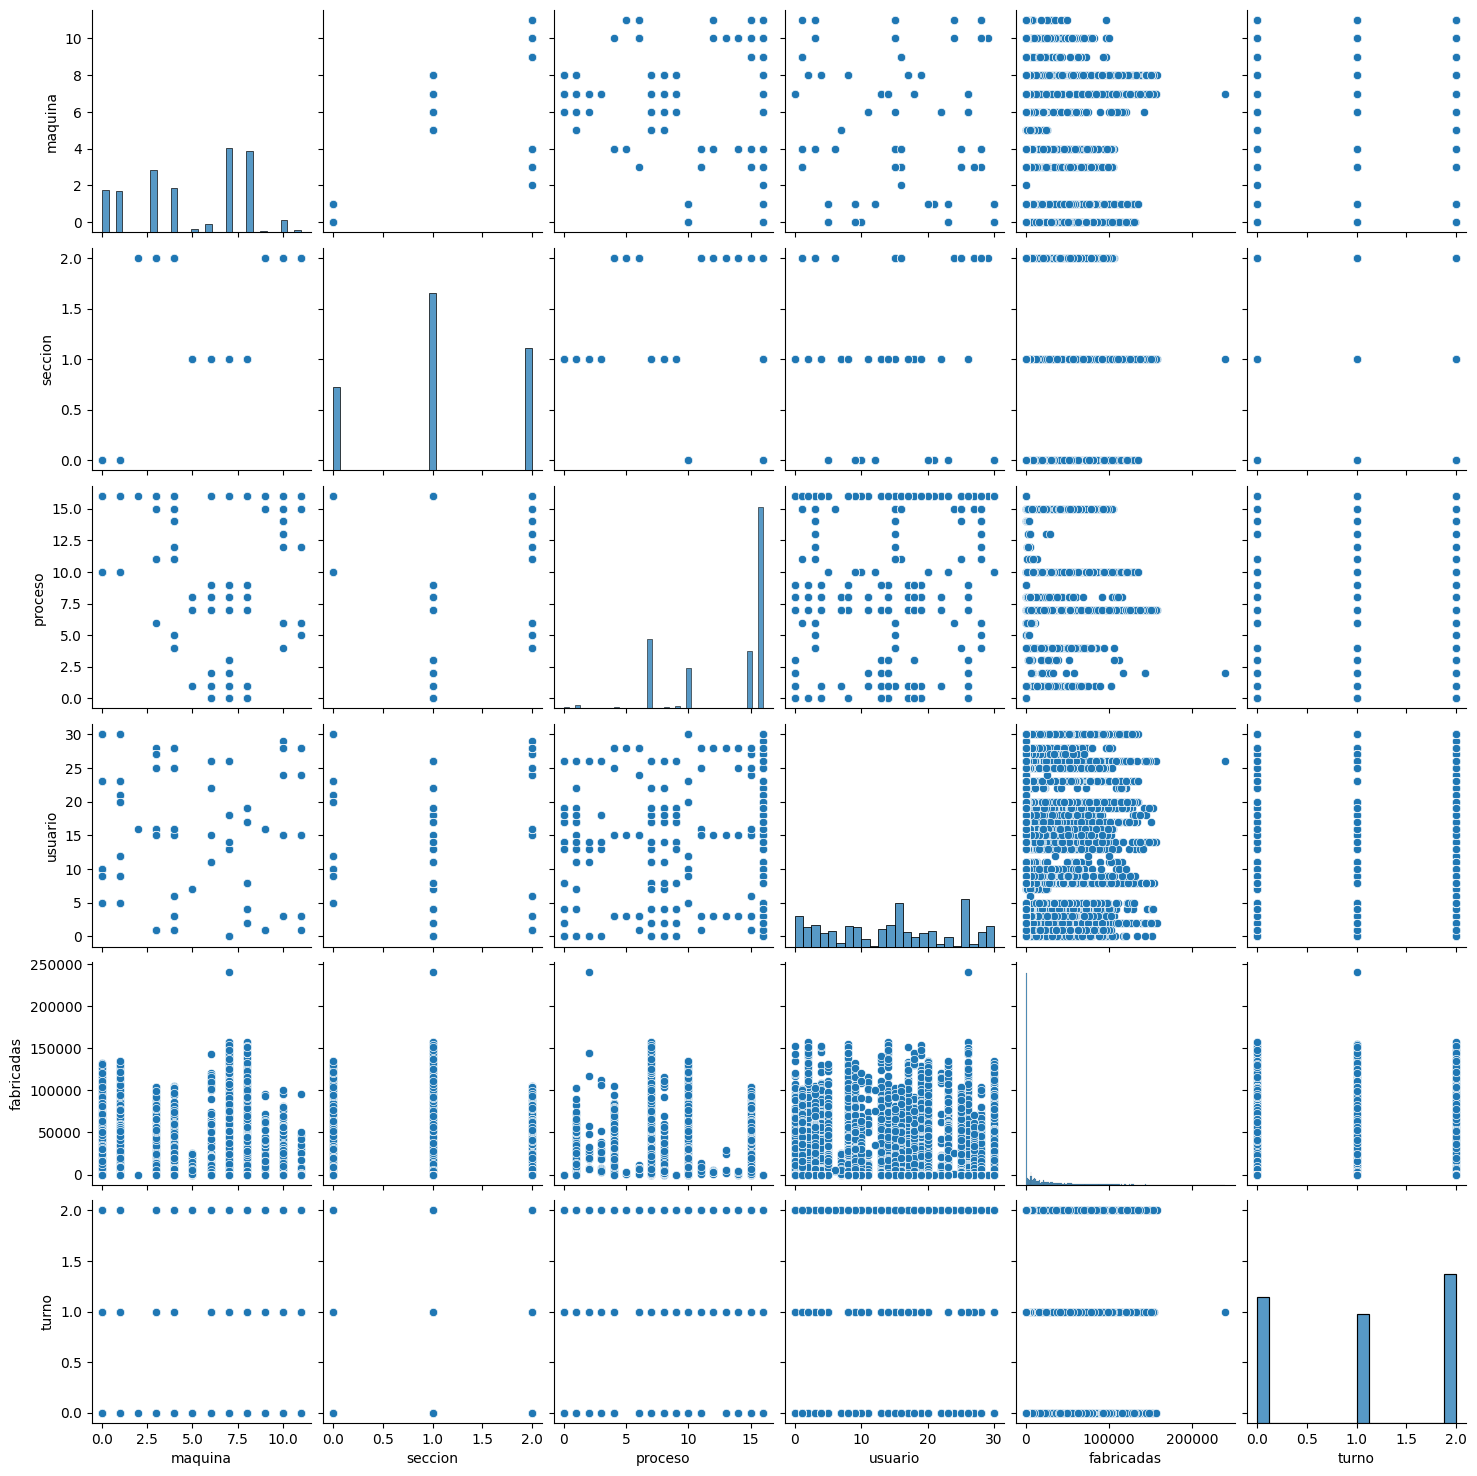

In [64]:
#Grafico entre predictores y variable a predecir

import seaborn as sns
import pandas as pd

# Copia del df para evitar modificar el original
df_plot = df_char.copy()

# Codificar variables categóricas
for col in features_ols:
    #Si es categorica en las features entonces asignarle un numero
        if features.get(col) == 'categorical':
                df_plot[col] = df_plot[col].astype('category').cat.codes

sns.pairplot(df_plot[features_ols])


In [65]:
#Para analizar la multicolinealidad e incluir las variables categoricas se utiliza el modelo (preprocesor sin predictor para codificar las variables a numeros y poder observarlos en la matriz de correlacion)

# Transformar con el preprocessor (numpy array)
X_transformed = pipeline.named_steps['preprocessor'].transform(X)


# Convertir a DataFrame con esos nombres
df_transformed = pd.DataFrame(X_transformed, columns=features_ols, index=X.index)
df_transformed


,maquina,seccion,proceso,usuario,fabricadas,turno
0,7.0,1.0,1.0,26.0,-0.526276,0.0
1,7.0,1.0,1.0,26.0,0.409432,0.0
2,7.0,1.0,1.0,26.0,-0.232765,2.0
3,7.0,1.0,1.0,13.0,1.241574,1.0
4,7.0,1.0,1.0,13.0,0.328849,1.0
...,...,...,...,...,...,...
18256,8.0,1.0,16.0,4.0,-0.526318,1.0
18257,8.0,1.0,16.0,4.0,-0.526318,1.0
18258,8.0,1.0,16.0,4.0,-0.526318,1.0
18259,8.0,1.0,16.0,8.0,-0.526318,0.0


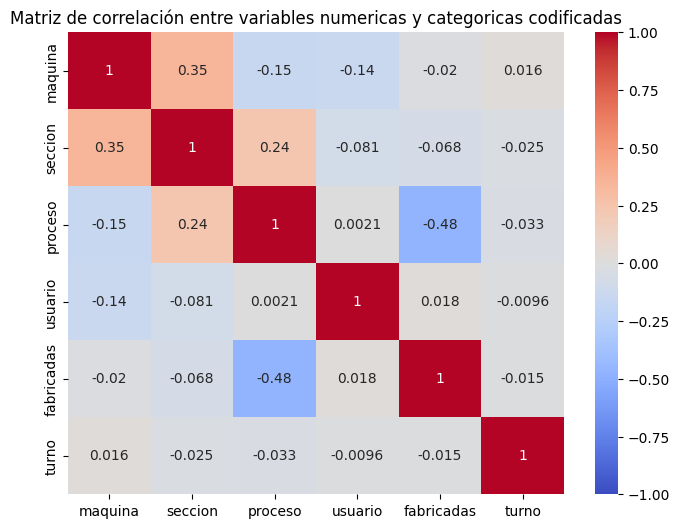

In [66]:
#Revisar la multicolinealidad de las variables
from matplotlib import pyplot as plt

from functions.plotter import corr_matrix_plot

corr_matrix_pearson = df_transformed.corr(method='pearson')
corr_matrix_plot(corr_matrix_pearson)

In [67]:
#VIF: Variance inflation factor - Consultado de internet: VIF mide cuánto aumenta la varianza de los coeficientes estimados debido a la colinealidad - segun el rango ideal es:
#VIF	Interpretación
#= 1	No hay multicolinealidad
#1 - 5	Aceptable, baja colinealidad
#5 - 10	Posible multicolinealidad.
#> 10	Alta multicolinealidad.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

X_numeric = df_transformed
X_with_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

print(vif_data)


     Variable        VIF
0       const  26.351135
1     maquina   1.260756
2     seccion   1.282322
3     proceso   1.499435
4     usuario   1.021375
5  fabricadas   1.322902
6       turno   1.002862
